# Building offline iPhone spam classifier using coreml

iOS 11 introduced message extension to filter spam messages and coreml to build custom machine learned models to predict spam or not. In this article I’ll go over all the steps I took to build a machine learning model and how I added it to an iphone project.

## Load Modules

In [107]:
%matplotlib inline
from io import open
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
#from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import os
plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'

/Users/darshansonde/anaconda2/envs/spam/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


# Data

SMSSpamCollection lets load and understand the data.


In [268]:
fpath = os.environ["ML_DATA_DIR"]
messages_file = os.path.join(fpath, 'Spam', 'SMS2018SpamInfoHam.tsv')

corpus = open(messages_file, encoding='latin1').readlines()
print("there are {} messages".format(len(corpus)))
    
corpus = [x.strip() for x in corpus]

for i,message in enumerate(corpus[:10]):
    print(i, message)

there are 30548 messages
0 info	Dear Customer, Purchase of INR AMT has been made on Debit Card linked to Acct on 30-Oct-17. Info: IIN*PAYTM      . The Available Balance is INR AMT.
1 info	Dear Customer, Govt. of India has mandated Aadhaar updation in bank accounts. Ensure uninterrupted banking services by updating your Aadhaar at goo.gl/Bzh9iA
2 info	Dear Customer, your Account XX has been debited with INR AMT on 06-Oct-17. Info: DECS*S.B.I., R.A.C.P.C.,*044. The Available Balance is INR AMT
3 info	Added Rs. AMT to your Paytm wallet. Transaction ID: DIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGIT. Current Balance: 1283.52. Rs100 Cashback on Bus Tickets
4 info	We have received a Paytm login request from a new phone at 02:09 PM, 23 October.If you did not attempt this, please raise a query at paytm.com/care or call us at 0120-3888388
5 info	Use DIGITDIGITDIGITDIGITDIGITDIGIT as your login OTP. OTP is confidential. Paytm never calls you asking for OTP. Sharing it with anyone gives them 

There spam and ham messages are separated by tab. we can use a csv loader to read.

In [303]:
messages = pd.read_csv(open(messages_file,encoding='latin1'), quoting=csv.QUOTE_NONE, sep='\t', names=['label', 'message'],skiprows=1)

messages['message'] = messages['message'].map(lambda text:text)
print(messages.head())

test_messages.describe()

  label                                            message
0  info  Dear Customer, Govt. of India has mandated Aad...
1  info  Dear Customer, your Account XX has been debite...
2  info  Added Rs. AMT to your Paytm wallet. Transactio...
3  info  We have received a Paytm login request from a ...
4  info  Use DIGITDIGITDIGITDIGITDIGITDIGIT as your log...


,label,message,prediction
count,495,495,495
unique,3,482,3
top,spam,"Your data pack gives free access to LIVE TV, M...",spam
freq,442,3,416


In [272]:
messages.reindex(np.random.permutation(messages.index))

,label,message
8087,ham,meet john's doctor tomorrow
11355,info,* KSRTC m-Ticket * from: SRIKALAHASTI to: THR...
17256,info,"PNR:8114546335,TRAIN:3644,DOJ:2012-01-02,FC,BO..."
12285,info,Bill dated 2009-10-26 for Rs 809 has been gene...
8055,ham,meet john on saturday or sunday
10942,info,* KSRTC m-Ticket * from: KOLHAPUR to: Pune Ps...
14671,info,"Dear Guest, Thanks for choosing Sumo Salad. Or..."
13655,info,"DEAR Jayden, THANK YOU FOR YOUR BOOKING (ORDER..."
13009,info,Bill dated 2014-02-23 for Rs 562 has been gene...
1549,ham,Hey I have your books.


In [273]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham     10009   9986  Are you still coming to my sister's graduation...    2
info    17938  17882  Delivered: Your package withGodanwas successfu...    4
spam     2600   2582  Grab your best deal now! The Great Crossword S...    3

In [274]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham     10009   9986  Are you still coming to my sister's graduation...    2
info    17938  17882  Delivered: Your package withGodanwas successfu...    4
spam     2600   2582  Grab your best deal now! The Great Crossword S...    3

In [275]:
d = {}
for m in messages.message:
    d[m.__class__] = m

print(d)

{<class 'str'>: 'Ã\x84Kr19Hm8443]&#13;&#10;Vehicle Details Not Found. Verify the Vehicle No or Contact Registering Authority for digitization the details.'}


In [276]:
messages['length'] = messages['message'].map(lambda text:len(text))
messages.head()

,label,message,length
0,info,"Dear Customer, Govt. of India has mandated Aad...",157
1,info,"Dear Customer, your Account XX has been debite...",143
2,info,Added Rs. AMT to your Paytm wallet. Transactio...,159
3,info,We have received a Paytm login request from a ...,174
4,info,Use DIGITDIGITDIGITDIGITDIGITDIGIT as your log...,180


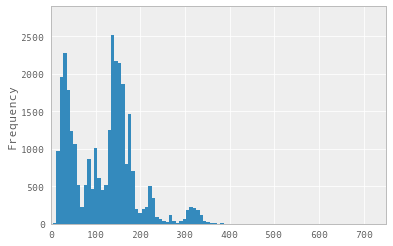

In [280]:
messages.length.plot(bins=100, kind='hist')
plt.axis([0,750,0,2900])
plt.show()

In [282]:
messages.length.describe()

count    30547.000000
mean       117.471176
std         73.264385
min          4.000000
25%         46.000000
50%        133.000000
75%        158.000000
max        768.000000
Name: length, dtype: float64

In [284]:
for _,m in messages[messages.length > 700].iterrows():
    print(m.label)
    print(m.message)
    print()
    print()

spam
Please give up LPG subsidy that you get as a member of middle or lower middle class - so says the great messiah Modi. Now if you give up LPG subsidy thaty doesn't mean that chotta Modi willnot pump black mone into shares of defunct companies held by Rajasthan CM Vasudhara Raje and her son Dushyant Singh. It doesn't also mean that money that had flowed into MP BJP coffers including that of CM Shivraj Singh Chouhan and RSS coffers will be diverted to pay subsidy for poorer classes. It also doesn't mean that Swaraj, our FM will not show gratitude in some form to chotta Modi in exile with suitable quid pro quo with regard to legal fees and commissions for hubby Swaraj Kaushal and daughter Bunty sorry Bansuri) Kaushal. Please give up LPG subsidy for Bara Modiji !




There is a really odd 540+ length message marked spam. removing that really odd case so it doesn't muck up the fv.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f500470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f7b6630>], dtype=object)

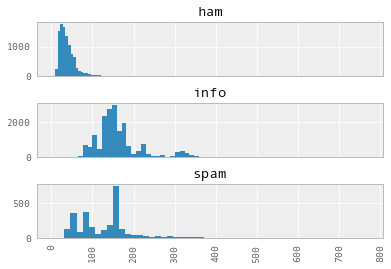

In [291]:
messages.hist(column='length', by='label', bins=50, sharex=True, layout=(3,1))


# Processing Data

we need to break the sentences into tokens and stem before we can use it. lets create a method for tokenizing the words.

In [324]:
#split corpus into tokens and replace "TIME"
#replace date with "DATE"
#replace digit in corpus with "DIGIT"
#replace URL with URL

def repl(text):
    text = re.sub('([0-1]?[0-9]|2[0-3]):[0-5][0-9]', 'TIME', text)
    text = re.sub('(?:(?:31(\/|-|\.)(?:0?[13578]|1[02]|(?:Jan|Mar|May|Jul|Aug|Oct|Dec)))\1|(?:(?:29|30)(\/|-|\.)(?:0?[1,3-9]|1[0-2]|(?:Jan|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec))\2))(?:(?:1[6-9]|[2-9]\d)?\d{2})$|^(?:29(\/|-|\.)(?:0?2|(?:Feb))\3(?:(?:(?:1[6-9]|[2-9]\d)?(?:0[48]|[2468][048]|[13579][26])|(?:(?:16|[2468][048]|[3579][26])00))))$|^(?:0?[1-9]|1\d|2[0-8])(\/|-|\.)(?:(?:0?[1-9]|(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep))|(?:1[0-2]|(?:Oct|Nov|Dec)))\4(?:(?:1[6-9]|[2-9]\d)?\d{2})', 'DATE', text)
    
    text = re.sub('([a-zA-Z0-9]+\.(?:com?|gl|ly)(?:\/[a-zA-Z0-9]*)*\/?)', 'EMAIL', text)
    text = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+(?:(\/\S+)*)', 'URL', text)
    text = re.sub('[a-zA-Z0-9]+\.(com?|gl|ly)(\/[a-zA-Z0-9]*)*\/?', 'URL', text)
    text = re.sub('\d', '0', text)
    return text

messages['repl']  =  messages['message'].map(repl)

for m in messages.repl:
    print(m)
    

Dear Customer, Govt. of India has mandated Aadhaar updation in bank accounts. Ensure uninterrupted banking services by updating your Aadhaar at EMAIL
Dear Customer, your Account XX has been debited with INR AMT on 00-Oct-00. Info: DECS*S.B.I., R.A.C.P.C.,*000. The Available Balance is INR AMT
Added Rs. AMT to your Paytm wallet. Transaction ID: DIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGIT. Current Balance: 0000.00. Rs000 Cashback on Bus Tickets
We have received a Paytm login request from a new phone at TIME PM, 00 October.If you did not attempt this, please raise a query at EMAIL or call us at 0000-0000000
Use DIGITDIGITDIGITDIGITDIGITDIGIT as your login OTP. OTP is confidential. Paytm never calls you asking for OTP. Sharing it with anyone gives them full access to your Paytm Wallet.
Save yourself from fraud: NEVER set a password suggested by anyone. Reset password link: URL (Do not forward this to anyone)
You paid UBER Rs. AMT. Now book your train e-tickets on Paytm & enjoy 000% 

Hi Sir, This message is from Tikona Broadband. Your Internet payment for this month is due Sir
Hi Vasant, I am your neighbor downstairs. There is lot of water seepage in my kitchen and bedroom. Radheesh told you are coming today evening or tomorrow morning, please call me asap, so that we can fix the issue. -gabriel 000.
Hi are u in delhi or outside? Have u got my mail?Plz respond to my calls...
Hi are you going to dance class?
Hi bradley, I am planning to take a leave today..as i am not well! -Gladbin
Hi bro..wer r u ?
Hi colin, we are leaving for Wilson Garden near new&#00; Empire hotel....What we do with Key??
Hi darling..what's up?
Hi dear..Are you coming for the Kitty party on Sunday?
Hi dearÂare u free on Monday
Hi dearÂtomorrow I am going to meet Harshali malhotraÂdo u want to join??
Hi dearÂwhats up!! Long time, No see.
Hi elijah, I will be late to office - Gladbin
Hi eric, &#00;&#00;My apologies, couldn't do it over the weekend. Will send the updated resume by 00am. &#00;&

Wanna grab a bite?
Wanna grab dinner before the movie tonight?
Wanna grab lunch tomorrow at 0?
Wanna grab some coffee tmrw at 0am?
Wanna hang at noon?
Wanna hang out sometime
Wanna hangout in the evening at Phoenix Mall?
Wanna have a HP movie marathon?
Wanna have dinner tomorrow?
Wanna help with dinner tonight?
Wanna hit the club tonight?
Wanna hit up Cafe' Brasil?
Wanna hit up the new earl grey shop at 0?
Wanna hit up the new toffee place?
Wanna join us for hiking on next weekend
Wanna meet up at the new burger joint after work today?
Wanna run to the store with me in 0?
Wanna study at the coffee shop on the 0th?
Wanna watch the grand finals at 0?
Want to bake cookies at my place Wednesday?
Want to get lunch at that sandwich place downtown?
Want to go downtown today?
Want to go get dinner at that new restaurant downtown?
Want to go help nurse puppies back to health tomorrow morning at 00 am?
Want to go shopping on Saturday?
Want to go to the library on Saturday?
Want to go to the movi

i should pick up clothes tomorrow from the tailor
i should remember to drop off mary at the railway station on sat
i should take tablets during dinner
i should wake up at 0 tomorrow
i should watch the hobbit day after tomorrow night TIMEpm
i should watch the hobbit on every sunday
i should watch the hobbit tonight
i should wish happy birthday to john
i shouldn't forget to meet john on sunday
i shouldn't forget to meet mrs. murfy
i shouldn't forget to wish mr. john smith on his birthday
i wanna get in touch with john and his wife
i wanna meet my friend at total mall
i want to analyse the proposal at 0pm
i want to attend that meeting today
i want to be the first one to wish him this time
i want to buy a bean bag tomorrow
i want to buy cheese cubes
i want to buy new clothes for christmas
i want to buy new clothes for john
i want to call the police
i want to discuss the proposal today evening with harry
i want to go home from 0th july to 00st july
i want to go to allahabad from 0th july to

party venue is ccd
party venue is lawyer's place
party venue is rohini's home
party venue is rohini's place
party will be after a week
party will be on every 00th this year
party will start at 0pm
party with tuesday
pat rohini on the back for a good job
pay $00,000 bucks to mary
pay 000 to john on diwali
pay 0000 advance to book the tickets
pay 00rs to lawyer
pay 00k in mom's account by today night
pay 00,000 bucks to mary
pay 000 bucks for abhanshu's gift
pay 000 to John for birthday party
pay 000 to nishu
pay 0k to the maid
pay John 000 rupees
pay John 000 rupees for last night's dinner
pay John 000 rupees for yesterday's dinner
pay John and Mary 000rs
pay John and Mary 000rs for dinner
pay John and her sister 000rs
pay John for yesterday's lunch
pay advance to book the tickets
pay all the bills in the first week of every month
pay all the bills within a week
pay all the dues by 0th evening 0 pm
pay bill by 00th
pay bill by 00 may
pay bill by 00th
pay bill by second
pay bill every mo

* KSRTC m-Ticket *  from: MERCARA MADIKERI to: OOTY PsngrName: Tyler TripCode: 0000MEROOT PNR No.: J00000000 JnyDate: 0000-00-00 DepTime: TIME  SeatNo.: 00, 00, 00, 00, 00, 00, 00, 00, 00  Class: AC chair  BoardingPt: MERCARA MADIKERI MG Road Txn Password: 0000 . Please carry your photo ID during journey. T&C apply. Visit  www.ksrtc.in
* KSRTC m-Ticket *  from: MERCARA MADIKERI to: PUTTAPARTHI PsngrName: Trenton TripCode: 0000MERPUT PNR No.: J00000000 JnyDate: 0000-00-00 DepTime: TIME  SeatNo.: 00, 00, 0, 00, 00, 00  Class: Non-AC chair  BoardingPt: MERCARA MADIKERI Bus Stand Road Txn Password: 0000 . Please carry your photo ID during journey. T&C apply. Visit  www.ksrtc.in
* KSRTC m-Ticket *  from: MERCARA MADIKERI to: Puducherry PsngrName: Landon TripCode: 0000MERPud PNR No.: J00000000 JnyDate: 0000-00-00 DepTime: TIME  SeatNo.: 0  Class: AC Sleeper  BoardingPt: MERCARA MADIKERI MG Road Txn Password: 0000 . Please carry your photo ID during journey. T&C apply. Visit  www.ksrtc.in
* K

DEAR Henry, THANK YOU FOR YOUR BOOKING (ORDER ID: 00000), YOUR ORDER HAS BEEN ASSIGNED TO Gage(0000000000) AND APPOINTMENT FOR SAMPLE COLLECTION IS SCHEDULED ON 0000-00-00 at TIME. FOR ASSISTANCE WHATSAPP US ON 0000000000.
DEAR Hunter, THANK YOU FOR YOUR BOOKING (ORDER ID: 00000), YOUR ORDER HAS BEEN ASSIGNED TO Jeffrey(0000000000) AND APPOINTMENT FOR SAMPLE COLLECTION IS SCHEDULED ON 0000-00-00 at TIME. FOR ASSISTANCE WHATSAPP US ON 0000000000.
DEAR Hunter, THANK YOU FOR YOUR BOOKING (ORDER ID: 00000), YOUR ORDER HAS BEEN ASSIGNED TO Wesley(0000000000) AND APPOINTMENT FOR SAMPLE COLLECTION IS SCHEDULED ON 0000-00-00 at TIME. FOR ASSISTANCE WHATSAPP US ON 0000000000.
DEAR Ian, THANK YOU FOR YOUR BOOKING (ORDER ID: 00000), YOUR ORDER HAS BEEN ASSIGNED TO Nicolas(0000000000) AND APPOINTMENT FOR SAMPLE COLLECTION IS SCHEDULED ON 0000-00-00 at TIME. FOR ASSISTANCE WHATSAPP US ON 0000000000.
DEAR Ian, THANK YOU FOR YOUR BOOKING (ORDER ID: 00000), YOUR ORDER HAS BEEN ASSIGNED TO Jared(000000

Maha Veer Auto Agency : Service of your car KA00B0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00J0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00H0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00E0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00H0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00H0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of your car KA00H0000 is due in 00 days on 0000-00-00. Please contact us at 0000000000 to book a service.
Maha Veer Auto Agency : Service of

Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00N0000 , Chauffer: Dominick, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00A0000 , Chauffer: Brady, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00V0000 , Chauffer: Mitchell, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00N0000 , Chauffer: Aiden, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00J0000 , Chauffer: Landon, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00P0000 , Chauffer: Israel, Cell: 0000000000 will reach you. T&C apply, visit www.EMAIL
Thank you for choosing KSRTC for 0000-00-00 at TIME. Cab:KA00Y0000 , Chauffer: Jalen, Cell: 0000000000 will reach yo

Welcome to Brentwood State Park R.No. 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Brevard College R.No. 000, 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to British Sky Broadcasting R.No. 000, 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Broc Theatre R.No. 000, 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Bronx-Whitestone Bridge R.No. 000, 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Brookfield Mall R.No. 000, 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to BrownForman R.No. 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Bryn Athyn College R.No. 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Burger King R.No. 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Burlington International Airport R.No. 000 Ch.In 0000-00-00 TIME Ch.out 0000-00-00 TIME.
Welcome to Butterfly Valley Botanical Area R.No. 000, 000 Ch.In 0000-00-00 TIME Ch.out 00

[Es Teler 00] Hi Henry, your reservation is confirmed for 0 people on 0000-00-00 at TIME. We can hold your table for a maximum of 00 mins.
[Espresso Vivace] Hi Cesar, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 00 mins.
[Esquires] Hi Aidan, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 0 mins.
[Essie 's Original Hot Dog shop] Hi Jackson, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 00 mins.
[Extreme Pita] Hi Miguel, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 00 mins.
[FATZ] Hi Joseph, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 0 mins.
[Faasos] Hi Timothy, your reservation is confirmed for 00 people on 0000-00-00 at TIME. We can hold your table for a maximum of 00 mins.
[Far Coa

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [326]:
stemmer = PorterStemmer()

def tokenize(message):
    """ removes punctuation and tokenizes the words and stems each word.
    """
    #msg = "".join([ch for ch in message if ch not in string.punctuation]) # get rid of punctuations
    tokens = word_tokenize(message) 
    stems = [stemmer.stem(x).lower() for x in tokens] #correct way to do
    #stems = [x.lower() for x in tokens] #iOS does not have porterstemmer, we are going to not use stem for now
    return stems

# Feature Vector

we need to convert the tokenized words into a vector to feed into the ml algorithm. we will create a TF-IDF feature vector from the sentence.

1. create count vector
2. convert convert vector into tf-idf vector


In [328]:
fv = CountVectorizer(analyzer=tokenize).fit(messages.repl)

print("Total number of words in array", len(fv.vocabulary_))

Total number of words in array 19810


Lets try to test how different words are represented in the CountVector.

In [329]:
print(fv.transform(["U what"]))

print("Second:")
print(fv.transform(["what U"]))


  (0, 17157)	1
  (0, 18449)	1
Second:
  (0, 17157)	1
  (0, 18449)	1


Notice sentences have same count vector generated. when we fit the vectorizer it creates a vocabulary. this vocabulary is used to create a count vector for all sentences.

Lets try to vectorize a full sentence from our corpus.

In [330]:
print(fv.transform([messages.message[3]]))

  (0, 115)	2
  (0, 1829)	3
  (0, 2970)	3
  (0, 3030)	1
  (0, 4722)	1
  (0, 6266)	1
  (0, 7592)	1
  (0, 8306)	1
  (0, 10757)	1
  (0, 12134)	1
  (0, 12309)	1
  (0, 12461)	1
  (0, 12686)	1
  (0, 13034)	1
  (0, 13222)	1
  (0, 13377)	1
  (0, 13399)	1
  (0, 13984)	1
  (0, 14092)	1
  (0, 14204)	1
  (0, 14327)	1
  (0, 16591)	1
  (0, 17409)	1
  (0, 18272)	1
  (0, 19593)	1



### Count Vector Vocabulary (words_array)

iPhone does not have a CountVectorizer so we would need to do this step if we are to analyze a sentence. we will use the vocabulary of countvectorizer and save into words array file.

words array file is the file with count positions of words and frequency of its occurance.

this is inturn used to calculate term frequency.

tf = Ft / Count(F)

Ft => frequency of term t in current document
Count(F) => total number of words in corpus. (max of Ft in words array)

lets save this file

In [331]:
import json

def default(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError
    
with open('words_array.json', 'w') as fp:
    json.dump(fv.vocabulary_, fp, default=default)

# Messages Feature Vector

Let's compose the feature vector for our entire corpus.

In [333]:
messages_fv = fv.transform(messages.repl)
print(messages_fv.shape)

(30547, 19810)


We will use TF-IDF transformer to transform the count vector of corpus into TFIDF vector.

In [210]:
tfidf = TfidfTransformer().fit(messages_fv)

# test tfidf of same message as before.
t = tfidf.transform(fv.transform([messages.message[3]]))
print(t)

t

  (0, 47181)	0.117124407602
  (0, 46740)	0.2484322264
  (0, 42991)	0.744010941955
  (0, 30460)	0.357796873013
  (0, 29589)	0.323425953669
  (0, 28698)	0.372005470977


<1x48630 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

We see that the values are all normalized and weights are given according to TF-IDF importance. this gives more relevancy for the model to use.

Lets compute the tfidf of the entire corpus.

In [211]:
messages_tfidf = tfidf.transform(messages_fv)
print(messages_tfidf.shape)

test_messages_tfidf = tfidf.transform(test_messages_fv)
print(test_messages_tfidf.shape)


(29998, 48630)
(495, 48630)


### IDF 

words idf is simple list of words and their IDF values

idf = log(N/Nt)

N => number of documents
N => number of documets with word t

we need to compute tfidf of sentence in iOS and we will need the words_idf values as input for computing the vector. lets save the idf array into a file. This is later used in the iOS code.

In [212]:
idf = {}
idf['idf'] = tfidf.idf_.tolist()

with open('words_idf.json', 'w') as fp:
    json.dump(idf, fp, default=default)

print("IDF of corpus :", tfidf.idf_)


IDF of corpus : [  8.669862    10.21030704  10.61577215 ...,  10.61577215  10.61577215
  10.61577215]


# Model Training

For the model we will use a simple Linear SVM. SVM seems to be getting the most accurate results and we can easily use this model in iPhone as well. lets create and train an Linear SVM model.

In [220]:
%time spam_detector = LinearSVC().fit(messages_tfidf, messages.label)

predictions = spam_detector.predict(test_messages_tfidf)

print('accuracy', accuracy_score(test_messages['label'], predictions))
print('confusion matrix\n', confusion_matrix(test_messages['label'], predictions, labels=['spam', 'info', 'ham']))
print('(row=expected, col=predicted)')


CPU times: user 220 ms, sys: 3.36 ms, total: 223 ms
Wall time: 221 ms
accuracy 0.878787878788
confusion matrix
 [[403   2  37]
 [ 13  26   8]
 [  0   0   6]]
(row=expected, col=predicted)


In [214]:
print(messages.label.unique())
print(test_messages.label.unique())

['ham' 'info' 'spam']
['info' 'spam' 'ham']


It looks like the model has got a really good accuracy. confusion matrix is also showing great results. 

Lets plot this and view this a little nicely

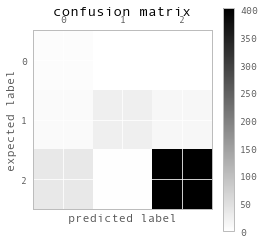

In [215]:
plt.matshow(confusion_matrix(test_messages['label'], predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [216]:
print(classification_report(test_messages['label'], predictions))

             precision    recall  f1-score   support

        ham       0.12      1.00      0.21         6
       info       0.93      0.55      0.69        47
       spam       0.97      0.91      0.94       442

avg / total       0.95      0.88      0.91       495



In [217]:
test_messages['prediction'] = predictions

In [229]:
cnt=0;
for _,row in test_messages.iterrows():
    if(row.prediction != row.label and 
      row.label == 'spam' and row.prediction == 'ham'):
        print(f"Truth:{row.label}")
        print(f"Predt:{row.prediction}")
        print(row.message)
        print()
        cnt += 1
print(cnt)
    

Truth:spam
Predt:ham
Sweet Lime/Nagpur Orange@Rs49/kg each Rs20 OFF-Surf Excel Easywash 1.5Kg MRP207 GTS Bullet Surti Kolam Rice25kg@Rs1425 Almond500g@Rs395 RUSH TO STAR BAZAAR!T&C

Truth:spam
Predt:ham
Last minute Gifting ideas?  100+ gift packs @ STAR-Ferrero Rocher,Haldiram,Cadbury,Dry Fruits & many more DHANTERAS Delight:Flat 25% OFF on all Steel utensils

Truth:spam
Predt:ham
Thinking what to gift this Diwali?  100+ gift packs and products available at Star. Chocolates, dry fruits, cookies, kitchen items & more.  Special discounts on bulk purchases.  View the catalogue here https://goo.gl/b4u4jE Call on +91 9029002233 or visit the store to place an order.

Truth:spam
Predt:ham
Last week of 53 years celebrations at JOS ALUKKAS Jwlry Jayanagar 3rd Blk!Win POLO Cars,Home Appliances,Gold Coins&Assured Gifts on purchases till Oct 31.Hurry!

Truth:spam
Predt:ham
It's Dad's turn to get a gift.Book a FREE portrait session with Dad &get a 8x12 print free only @GK Vale Marathahalli.Cpn0616C

# Convert to CoreML

In [21]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(spam_detector, "message", "spam_or_not")

#set parameters of the model
coreml_model.short_description = "Classify whether message is spam or not"
coreml_model.input_description["message"] = "TFIDF of message to be classified"
coreml_model.output_description["spam_or_not"] = "Whether message is spam or not"
#save the model
coreml_model.save("SpamMessageClassifier.mlmodel")